# Analyzing CIA Factbook Data Using SQL
### By Abhimanyu Verma

In this project, we will work with data from the [CIA World Factbook](https://www.cia.gov/the-world-factbook/), which is an annual publication of the US Central Intelligence Agency. It provides basic intelligence by summarizing information about countries and regions worldwide. The factbook contains a mix of demographic and geographic data, among many more.

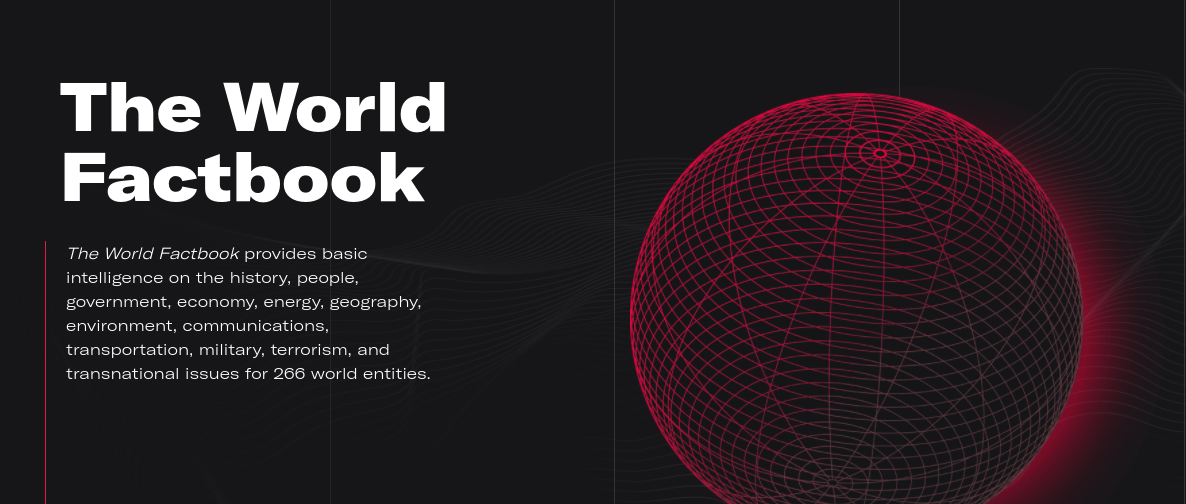

In this project, we will use SQL in Jupyter Notebook to analyze data from this [SQLite factbook.db database](https://dsserver-prod-resources-1.s3.amazonaws.com/257/factbook.db). The goal is to identify the leading and lagging territories of the world based on demographic indicators like population, mortality, and fertility.

## Connecting to the CIA factbook database

In [1]:
%%capture
%load_ext sql
%sql sqlite:///factbook.db

'Connected: None@factbook.db'

## Understanding the schema of the database

In [2]:
%%sql
SELECT *
  FROM sqlite_master
 WHERE type='table';

Done.


type,name,tbl_name,rootpage,sql
table,sqlite_sequence,sqlite_sequence,3,"CREATE TABLE sqlite_sequence(name,seq)"
table,facts,facts,47,"CREATE TABLE ""facts"" (""id"" INTEGER PRIMARY KEY AUTOINCREMENT NOT NULL, ""code"" varchar(255) NOT NULL, ""name"" varchar(255) NOT NULL, ""area"" integer, ""area_land"" integer, ""area_water"" integer, ""population"" integer, ""population_growth"" float, ""birth_rate"" float, ""death_rate"" float, ""migration_rate"" float)"


As we can see there are two tables in the database
1. sqlite_sequence
2. facts

The sqlite_sequence table does not contain any columns.
<br>The facts table contains information on population, birth rate, migration rate and many more.

Hence, we will work with the facts table.

#### A. Examining the first 5 rows of facts table

In [3]:
%%sql
SELECT *
  FROM facts
 LIMIT 5;

Done.


id,code,name,area,area_land,area_water,population,population_growth,birth_rate,death_rate,migration_rate
1,af,Afghanistan,652230,652230,0,32564342,2.32,38.57,13.89,1.51
2,al,Albania,28748,27398,1350,3029278,0.3,12.92,6.58,3.3
3,ag,Algeria,2381741,2381741,0,39542166,1.84,23.67,4.31,0.92
4,an,Andorra,468,468,0,85580,0.12,8.13,6.96,0.0
5,ao,Angola,1246700,1246700,0,19625353,2.78,38.78,11.49,0.46


The facts table contains 11 columns:

1. id - Entry row number
2. code — The country's internet code
3. name — Name of the country
4. area — The country's total area (both land and water)
5. area_land — The country's land area in square kilometers
6. area_water — The country's water area in square kilometers
7. population — Whole number of people or inhabitants in the country
8. population_growth — The country's population growth as a percentage
9. birth_rate — The number of births per year per 1,000 inhabitants
10. death_rate — The number of deaths per year per 1,000 inhabitants
11. migration_rate — The difference between the number of persons entering & leaving the country every year per 1,000 persons

#### B. Calculating the total number of records in the database

In [4]:
%%sql
SELECT COUNT(*) AS num_records,
       COUNT(DISTINCT name) AS unique_countries
  FROM facts;

Done.


num_records,unique_countries
261,261


261 records and countries seem wrong because we know there are only 195 countries in the world right now.

The answer lies in the way the CIA categorizes its information. As of July 2011, The World Factbook comprises 267 entities divided into the following categories:

1. Independent countries: The CIA defines these as people "politically organized into a sovereign state with a definite territory." There are 195 entities in this category.
2. Others: Places set apart from the list of independent countries. Currently, there are two: Taiwan and the European Union.
3. Dependencies and Areas of Special Sovereignty: Places affiliated with another country. There are 58 in total.
4. Miscellaneous: Antarctica and places in dispute. There are six such entities.
5. Other entities: The world and the oceans. There are five oceans and the world (the World entry is intended as a summary of the other entries).

## Exploring Total Population

#### A. Let's understand the population distribution in the database.

In [5]:
%%sql 
SELECT MIN(population) AS min_population,
       CAST(AVG(population) AS Integer) AS avg_population,
       MAX(population) AS max_pop
  FROM facts;

Done.


min_population,avg_population,max_pop
0,62094928,7256490011


It is best to identify what these entities are.

In [6]:
%%sql
SELECT name, population
  FROM facts
 WHERE population = (SELECT MIN(population) FROM facts) 
    OR population = (SELECT MAX(population) FROM facts);

Done.


name,population
Antarctica,0
World,7256490011


This explains the numbers a lot better but lets gain a better insight by excluding these 2 entities.

In [7]:
%%sql 
SELECT MIN(population) AS min_pop,
       CAST(AVG(population) AS Integer) AS avg_pop,
       MAX(population) AS max_pop
  FROM facts
 WHERE population != 0 
   AND name != 'World';

Done.


min_pop,avg_pop,max_pop
48,32377011,1367485388


The minimum population is 48, the maximum is over 1.3 billion and the average population centers around 32 million.

#### B. 5 most populated countries and their world proportions

In [8]:
%%sql 
SELECT name AS "5 Most Populated Countries",
       population,
       ROUND(
              CAST(population AS Float) / 
              CAST((SELECT MAX(population) FROM facts) AS Float)
             , 3) AS world_proportion
  FROM facts
 WHERE population <> 0 
   AND name NOT IN ('World', 'European Union')
 ORDER BY Population DESC
 LIMIT 5;

Done.


5 Most Populated Countries,population,world_proportion
China,1367485388,0.188
India,1251695584,0.172
United States,321368864,0.044
Indonesia,255993674,0.035
Brazil,204259812,0.028


China is the world's most populated country, with about 1.37 billion people. India follows behind with about 1.26 billion people. 36% of the world's total population comes from China (18.8%) and India (17.2%) alone.
The United States (4.4% of the world total), Indonesia (3.5%), and Brazil (2.8%) follow far behind and constitute a combined 11% of the world's population.

#### C. Countries with the smallest total population

In [9]:
%%sql 
SELECT name AS "5 Least Populated Countries",
       population
  FROM facts
 WHERE population <> 0 
   AND name <> 'Antartica'
 ORDER BY population
 LIMIT 5;

Done.


5 Least Populated Countries,population
Pitcairn Islands,48
Cocos (Keeling) Islands,596
Holy See (Vatican City),842
Niue,1190
Tokelau,1337


The least populated territories are the Pitcairn Islands (48 inhabitants), Cocos Islands (596), Holy See (842), Niue (1190), and Tokelau (1337).

## Exploring population density

Since there are territories where population density or the land area may be zero or null, let's count them before moving further into the analysis

In [10]:
%%sql
SELECT COUNT(*)
  FROM facts
 WHERE population = 0
     OR population IS NULL
     OR area_land = 0
     OR area_land IS NULL;

Done.


COUNT(*)
29


29 records meet these criteria so we will exclude these records.

#### A. Countries with the highest population density

In [11]:
%%sql
SELECT name AS country, area_land, population,
       CAST(
            CAST(population AS Float) / 
              CAST(area_land AS Float) 
           AS Integer) AS population_density
  FROM facts
 WHERE name NOT IN (SELECT name
                      FROM facts
                     WHERE population = 0
                         OR population IS NULL
                         OR area_land = 0
                         OR area_land IS NULL
                   )
 ORDER BY population_density DESC
 LIMIT 10;

Done.


country,area_land,population,population_density
Macau,28,592731,21168
Monaco,2,30535,15267
Singapore,687,5674472,8259
Hong Kong,1073,7141106,6655
Gaza Strip,360,1869055,5191
Gibraltar,6,29258,4876
Bahrain,760,1346613,1771
Maldives,298,393253,1319
Malta,316,413965,1310
Bermuda,54,70196,1299


The Chinese territory of Macau has the world's highest population density at 21,168 people/km²

#### B. Countries with the lowest population density

In [12]:
%%sql
SELECT name AS country, area_land, population,
       ROUND(
            CAST(population AS Float) / 
              CAST(area_land AS Float) 
            , 3) AS population_density
  FROM facts
-- Filter out countries with zero or missing population/land area
 WHERE name NOT IN (SELECT name
                      FROM facts
                     WHERE population = 0
                         OR population IS NULL
                         OR area_land = 0
                         OR area_land IS NULL
                   )
 ORDER BY population_density
 LIMIT 10;

Done.


country,area_land,population,population_density
Greenland,2166086,57733,0.027
Svalbard,62045,1872,0.03
Falkland Islands (Islas Malvinas),12173,3361,0.276
Pitcairn Islands,47,48,1.021
Mongolia,1553556,2992908,1.926
Western Sahara,266000,570866,2.146
Namibia,823290,2212307,2.687
Australia,7682300,22751014,2.961
Iceland,100250,331918,3.311
Mauritania,1030700,3596702,3.49


The world's least-densely populated territory is Greenland with a rate of 0.027 people per square km. This is because most of Greenland is covered in ice.

## Mortality & Fertility

These 2 metrics determine the change in the world population:
1. The number of babies born
2. The number of people dying

In [13]:
%%sql 
SELECT birth_rate, death_rate,
       ROUND((birth_rate / death_rate), 2) AS birth_to_death_ratio
  FROM facts
 WHERE name = 'World';

Done.


birth_rate,death_rate,birth_to_death_ratio
18.6,7.8,2.38


With about 2.4 births for every death, the world's population is increasing.

#### A. Countries with the highest birth rates

In [14]:
%%sql 
SELECT name AS country, birth_rate
  FROM facts
 WHERE name != 'World'
 ORDER BY birth_rate DESC
 LIMIT 10;

Done.


country,birth_rate
Niger,45.45
Mali,44.99
Uganda,43.79
Zambia,42.13
Burkina Faso,42.03
Burundi,42.01
Malawi,41.56
Somalia,40.45
Angola,38.78
Mozambique,38.58


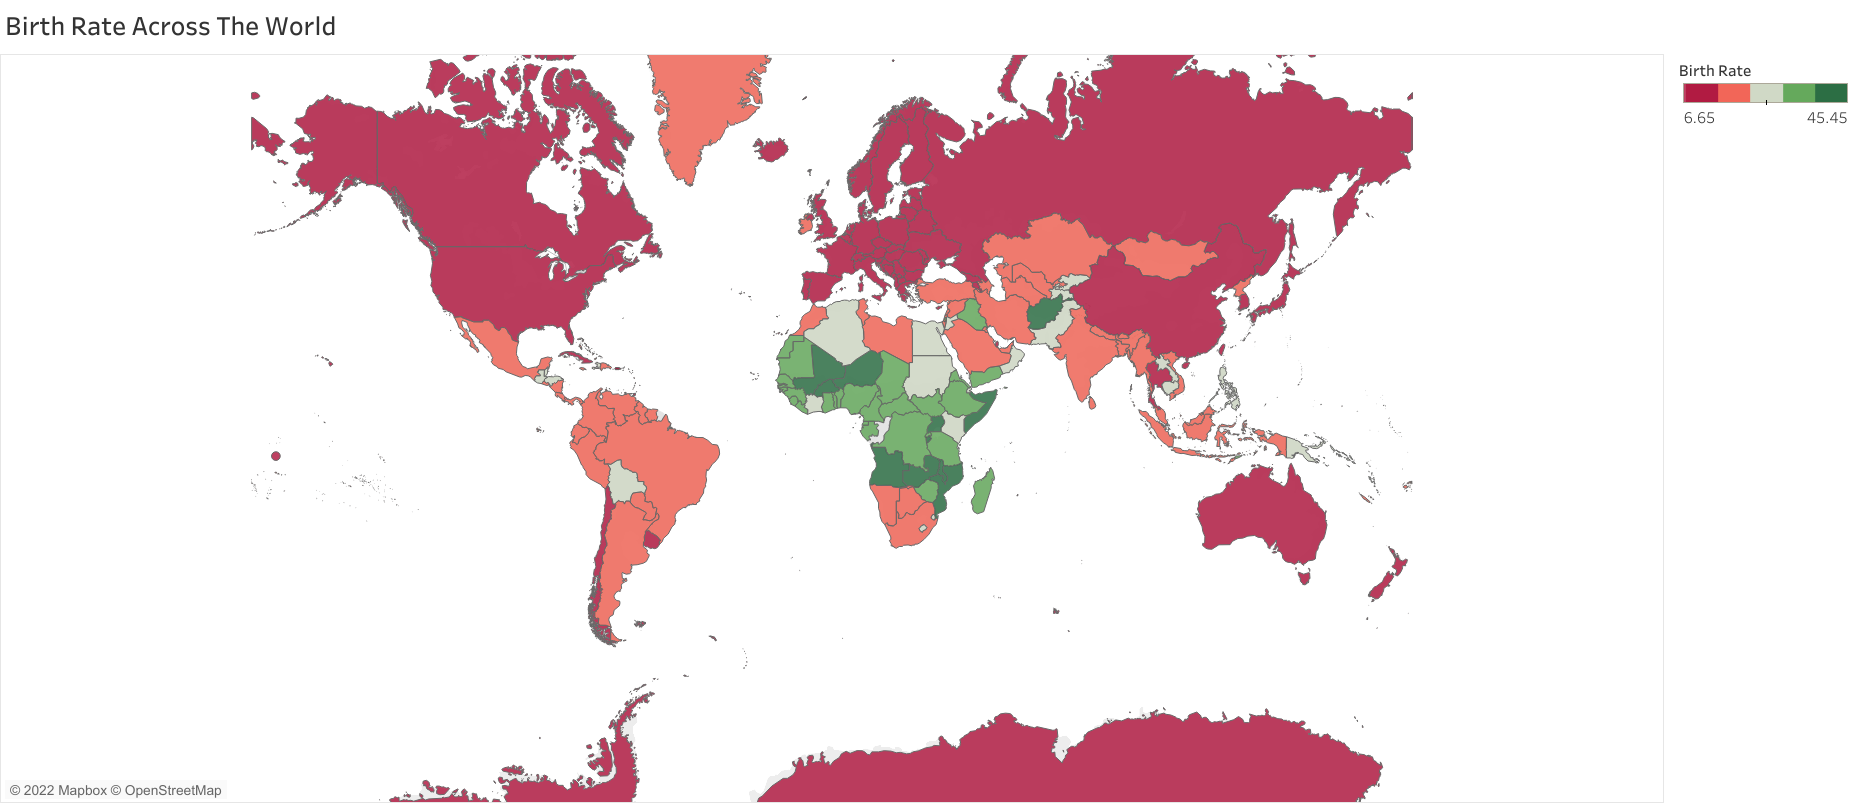

#### B. Countries with the lowest birth rates

In [15]:
%%sql 
SELECT name AS country, birth_rate
  FROM facts
 WHERE name != 'World'
     AND birth_rate IS NOT NULL
 ORDER BY birth_rate ASC
 LIMIT 10;

Done.


country,birth_rate
Monaco,6.65
Saint Pierre and Miquelon,7.42
Japan,7.93
Andorra,8.13
"Korea, South",8.19
Singapore,8.27
Slovenia,8.42
Germany,8.47
Taiwan,8.47
San Marino,8.63


#### C. Countries with the highest death rates

In [16]:
%%sql 
SELECT name AS country, death_rate
  FROM facts
 WHERE name != 'World'
 ORDER BY death_rate DESC
 LIMIT 10;

Done.


country,death_rate
Lesotho,14.89
Ukraine,14.46
Bulgaria,14.44
Guinea-Bissau,14.33
Latvia,14.31
Chad,14.28
Lithuania,14.27
Namibia,13.91
Afghanistan,13.89
Central African Republic,13.8


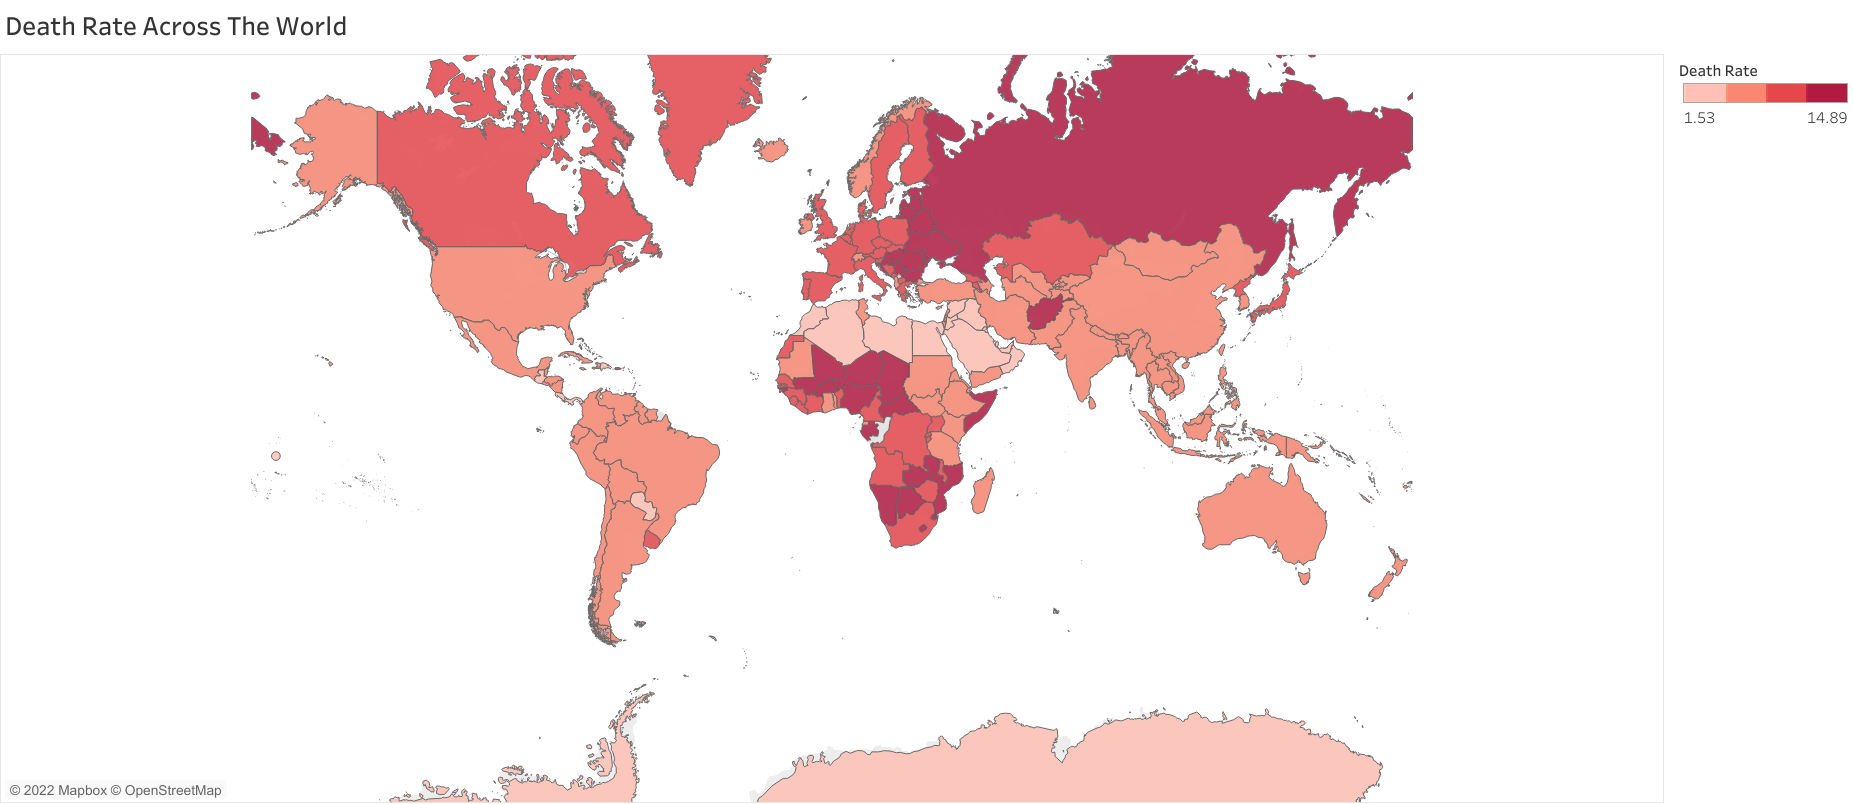

#### D. Countries with the lowest death rates

In [17]:
%%sql 
SELECT name AS country, death_rate
  FROM facts
 WHERE name != 'World'
     AND death_rate IS NOT NULL
 ORDER BY death_rate
 LIMIT 10;

Done.


country,death_rate
Qatar,1.53
United Arab Emirates,1.97
Kuwait,2.18
Bahrain,2.69
Gaza Strip,3.04
Turks and Caicos Islands,3.1
Saudi Arabia,3.33
Oman,3.36
Singapore,3.43
West Bank,3.5


Qatar has the lowest mortality rate in the world at 1.53 deaths per 1,000 people. The UAE (1.97), Kuwait (2.8), and Bahrain (2.69) follow behind. These countries are renowned for their improved health care system, technologically advanced facilities, and ability to deliver some of the world's best patient care.

<br>Here is another interesting pattern: Six of the ten countries on this list (Saudi Arabia, Kuwait, the United Arab Emirates, Qatar, Bahrain, and Oman) belong to the Gulf Cooperation Council (GCC). In fact, all members of the council are present on the list.

#### E. Countries with the highest birth-to-death ratio

In [18]:
%%sql 
SELECT name AS country, birth_rate, death_rate,
       ROUND((birth_rate / death_rate), 2) AS birth_to_death_ratio
  FROM facts
 WHERE name != 'World'
 ORDER BY birth_to_death_ratio DESC
 LIMIT 10;

Done.


country,birth_rate,death_rate,birth_to_death_ratio
Gaza Strip,31.11,3.04,10.23
Kuwait,19.91,2.18,9.13
Iraq,31.45,3.77,8.34
United Arab Emirates,15.43,1.97,7.83
Oman,24.44,3.36,7.27
Jordan,25.37,3.79,6.69
Solomon Islands,25.77,3.85,6.69
West Bank,22.99,3.5,6.57
Qatar,9.84,1.53,6.43
Vanuatu,25.04,4.09,6.12


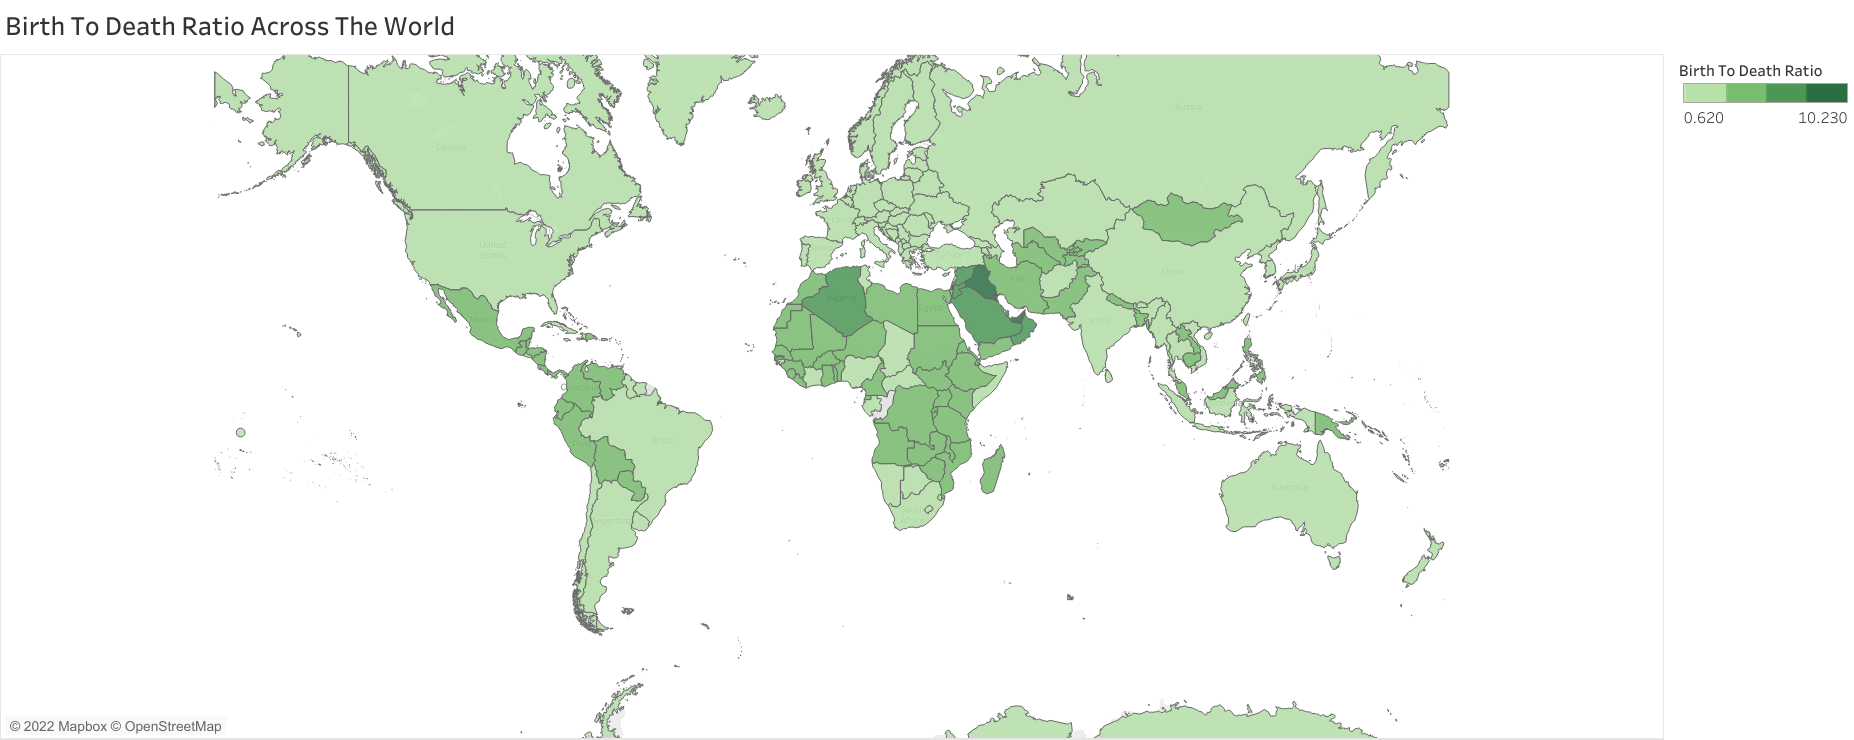

#### F. Countries with the lowest birth-to-death ratio

In [19]:
%%sql 
SELECT name AS country, birth_rate, death_rate,
       ROUND((birth_rate / death_rate), 2) AS birth_to_death_ratio
  FROM facts
 WHERE name != 'World'
     AND birth_to_death_ratio NOT NULL
 ORDER BY birth_to_death_ratio
 LIMIT 10;

Done.


country,birth_rate,death_rate,birth_to_death_ratio
Bulgaria,8.92,14.44,0.62
Serbia,9.08,13.66,0.66
Latvia,10.0,14.31,0.7
Lithuania,10.1,14.27,0.71
Hungary,9.16,12.73,0.72
Monaco,6.65,9.24,0.72
Germany,8.47,11.42,0.74
Slovenia,8.42,11.37,0.74
Ukraine,10.72,14.46,0.74
Saint Pierre and Miquelon,7.42,9.72,0.76


## Countries with the fastest declining population

To identify the fastest declining populations, we select countries that meet the following criteria:

1. A birth-to-death ratio < 1 (indicates the absence of natural increase)
2. Little to no population growth (population growth < 1)
3. Very low immigration levels (migration rate < 1)

In [20]:
%%sql
SELECT name AS country,
       ROUND((birth_rate / death_rate), 2) AS birth_death_ratio, 
       population_growth,
       migration_rate
  FROM facts
 WHERE birth_death_ratio < 1
     AND population_growth < 1
     AND migration_rate < 1
 ORDER BY migration_rate, birth_death_ratio, population_growth;

Done.


country,birth_death_ratio,population_growth,migration_rate
Serbia,0.66,0.46,0.0
Japan,0.83,0.16,0.0
Romania,0.77,0.3,0.24
Bulgaria,0.62,0.58,0.29
Slovenia,0.74,0.26,0.37
Bosnia and Herzegovina,0.91,0.13,0.38
Poland,0.96,0.09,0.46
Belarus,0.8,0.2,0.7


Aside from Japan,all the countries (Serbia, Romania, Bulgaria, Slovenia, Bosnia and Herzegovina, Poland and Belarus) are located in or near Eastern Europe. The first cause of the rapidly declining population around East Europe is birth rates. According to the Peterson Institute for International Economics (PIIE), the region's birth rates have fallen since the collapse of the Soviet Union.

The falling birth rate is also not enough to offset deaths and citizens leaving their country to live elsewhere. Eastern Europe saw several waves of emigration following the European Union’s (EU) border expansions in 2004 and 2007. The PIIE reports that by 2016, 6.3 million Eastern Europeans had emigrated to other EU countries.

Japan
Birth rates have fallen continuously in Japan since 1970. Japan’s fertility rate is plotted against various forecasts over the years. These forecasts headed upwards, but in reality rates decreased consistently everytime:

## Conclusion

We used the CIA World factbook data to identify the leading and lagging territories of the world. Our analysis is based on demographic indicators like population, mortality, and fertility.

1. With 46% of the world's total population, China, India, the United States, Indonesia, and Brazil are the most populated countries.
2. The least populated world locations are majorly Islands and dependencies.
3. Due to their small land area, Macau, Monaco, Singapore, and Hong Kong are more densely populated than the rest of the world.
4. Fertility is highest in Africa and lowest in Europe and Asia.
5. Some African countries (Lesotho, Guinea-Bissau) and Eastern European countries (Bulgaria, Lithuania, Serbia) record the highest death rates.
6. The Gulf cooperation countries of the Middle-East record the lowest death rates.
7. Population is rapidly declining in Japan and South-East Europe. This occurrence is due to reducing birth rates, increasing deaths, and emigration to other countries.

## Limitation

The CIA collated this data between 2014 & 2015. As a result, our findings are limited to the period the data was published. They certainly do not reflect the current state of the world's countries.